In [1]:
import pyspark
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,BooleanType,DoubleType, ArrayType, LongType
from pyspark import  SparkContext
from pyspark.sql import SparkSession

import time

start = time.time()

spark = SparkSession.builder.getOrCreate()


path_instance_events = "/home/migvasc/aula_spark/instance_events/*.csv"
path_collection_events = "/home/migvasc/aula_spark/collection_events/*.csv"

# Loading DFs
df_instance_events = spark.read.csv(path_instance_events,header=True,sep=",")
df_collection_events = spark.read.csv(path_collection_events,header=True,sep=",")
# updating schema of the time column
df_collection_events  = df_collection_events.withColumn("time_new", (df_collection_events .time ).cast(LongType() ) )  
df_collection_events = df_collection_events.drop(df_collection_events.time)
df_collection_events = df_collection_events.withColumnRenamed('time_new','time')



total_rows = 0
total_rows += df_instance_events.count()
total_rows += df_collection_events.count()

print(f'total rows {total_rows}')

end = time.time()
print(f"Executed in {end - start} s")





22/06/14 13:34:54 WARN Utils: Your hostname, migvasc-Precision-3561 resolves to a loopback address: 127.0.1.1; using 172.115.3.212 instead (on interface wlp0s20f3)
22/06/14 13:34:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/06/14 13:34:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


total rows 315795276
Executed in 17.166407585144043 s


### Questões:

- Qual é a utilização de recursos computacionais (CPU e memória) do cluster pelos jobs que estão em execução durante a semana ?


In [7]:
from pyspark.sql.types import IntegerType

df_jobs_running  = df_instance_events.filter('type == 3')



df_jobs_running  = df_jobs_running.filter(df_jobs_running.time > 600000)
# New column to convert time (in microseconds) to hours
df_jobs_running = df_jobs_running.withColumn("time_hour", (df_jobs_running.time / 3600000000).cast(LongType() ) )

# Average of memory requested by hour
df_jobs_running = df_jobs_running.groupby('time_hour').agg({"`resource_request.memory`":'avg'}).show()


# Alterar os filtros para pegar detalhes de outros recursos computacionais, e também de categorias de jobs

== Physical Plan ==
*(1) Project [type#17, collection_id#18, priority#19, instance_index#20, resource_request.cpus#21, resource_request.memory#22, cast(time#16 as bigint) AS time#46L]
+- *(1) Filter (isnotnull(type#17) AND (cast(type#17 as int) = 3))
   +- FileScan csv [time#16,type#17,collection_id#18,priority#19,instance_index#20,resource_request.cpus#21,resource_request.memory#22] Batched: false, DataFilters: [isnotnull(type#17), (cast(type#17 as int) = 3)], Format: CSV, Location: InMemoryFileIndex[file:/home/migvasc/Desktop/OLD LAPTOP/PHD/google_traces/testing downloading/ins..., PartitionFilters: [], PushedFilters: [IsNotNull(type)], ReadSchema: struct<time:string,type:string,collection_id:string,priority:string,instance_index:string,resourc...




AttributeError: 'NoneType' object has no attribute 'filter'

In [ ]:
df_instance_events.filter('type == 3').collect().explain(extended= True)

- Quantos jobs são submetidos por hora? 


In [4]:
inicio = time.time()

from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import sum
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,BooleanType,DoubleType, ArrayType, LongType
import matplotlib.pyplot as plt

type_submit = 0


df_jobs_sub  = df_collection_events.filter('type == 0')# and time >=600000')
df_jobs_sub  =df_jobs_sub.filter((df_jobs_sub.time > 600000000) & (df_jobs_sub.time < 604800000000 ))# and time >=600000')

df_jobs_sub  = df_jobs_sub .withColumn("time_hour", (df_jobs_sub .time / 3600000000).cast(LongType() ) )  

df_jobs_sub = df_jobs_sub.groupby('time_hour').agg({'time_hour':'count'})
df_jobs_sub = df_jobs_sub.orderBy('time_hour', ascending=False)#.show()
df_jobs_sub.show()#df_jobs_sub.orderBy('count(time_hour)', ascending=False).show()



#Total de jobs submetidos na semana
df_jobs_sub.select(sum('count(time_hour)')).show()


df = df_jobs_sub.withColumnRenamed('count(time_hour)','total')
df = df.orderBy('time_hour', ascending=True).show()
fim = time.time()
print(f'Tempo para executar (sem cache): {fim-inicio} s' )


#data = df.select(['time_hour','total']).collect()



#x_ts = [val.time_hour for val in data]
#y_ans_val = [val.total for val in data]
#color='green', marker='o', linestyle='dashed',      linewidth=2

#plt.plot(x_ts,y_ans_val,linewidth=3)
#plt.xlabel("Time (hours)")
#plt.ylabel("Number of arriving Jobs")
#plt.title("Google's Trace 2019 - Job submission - week 1")



+---------+----------------+
|time_hour|count(time_hour)|
+---------+----------------+
|      167|            1095|
|      166|            1161|
|      165|            1432|
|      164|            1088|
|      163|            1189|
|      162|            1131|
|      161|            1262|
|      160|            1529|
|      159|            1545|
|      158|            1124|
|      157|            1218|
|      156|            1186|
|      155|            1287|
|      154|            1127|
|      153|            1162|
|      152|            1145|
|      151|            1463|
|      150|            1394|
|      149|             848|
|      148|            1420|
+---------+----------------+
only showing top 20 rows

+---------------------+
|sum(count(time_hour))|
+---------------------+
|               168453|
+---------------------+

+---------+-----+
|time_hour|total|
+---------+-----+
|        0|  789|
|        1|  939|
|        2|  670|
|        3| 1003|
|        4|  984|
|        5|  

- Quantas tarefas são submetidos por hora? 

+---------+----------------+
|time_hour|count(time_hour)|
+---------+----------------+
|      167|          476350|
|      166|          271023|
|      165|          269182|
|      164|          441308|
|      163|          593154|
|      162|          360036|
|      161|          314019|
|      160|          349110|
|      159|          484493|
|      158|          378961|
|      157|          450241|
|      156|          575002|
|      155|          708947|
|      154|          372883|
|      153|          366065|
|      152|          456500|
|      151|          454008|
|      150|          492985|
|      149|          476872|
|      148|          433687|
+---------+----------------+
only showing top 20 rows



+---------------------+
|sum(count(time_hour))|
+---------------------+
|             73988260|
+---------------------+



Text(0.5, 1.0, "Google's Trace 2019 - Job submission - week 1")

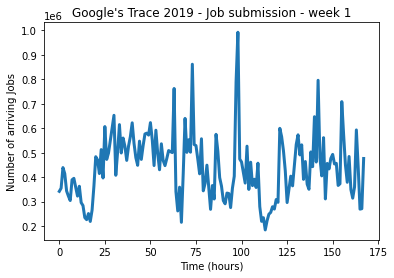

In [10]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,BooleanType,DoubleType, ArrayType, LongType
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import sum
import matplotlib.pyplot as plt


df_tasks_sub  = df_instance_events.filter((df_instance_events.time > 600000000)&(df_instance_events.time < 604800000000))
df_tasks_sub  = df_tasks_sub.filter('type == 0')# and time >=600000')
df_tasks_sub = df_tasks_sub.withColumn("time_hour", (df_tasks_sub.time / 3600000000).cast(LongType() ) )
df_tasks_sub.orderBy('time', ascending=False)#.show()
df_tasks_sub = df_tasks_sub.groupby('time_hour').agg({'time_hour':'count'})
df_tasks_sub.orderBy('time_hour', ascending=False).show()

#Total de tarefas submetidos na semana
df_tasks_sub.select(sum('count(time_hour)')).show()


df = df_tasks_sub.withColumnRenamed('count(time_hour)','total')
df = df.orderBy('time_hour', ascending=True)#.show()

data = df.select(['time_hour','total']).collect()

x_ts = [val.time_hour for val in data]
y_ans_val = [val.total for val in data]
#color='green', marker='o', linestyle='dashed',      linewidth=2

plt.plot(x_ts,y_ans_val,linewidth=3)
plt.xlabel("Time (hours)")
plt.ylabel("Number of arriving Jobs")
plt.title("Google's Trace 2019 - Job submission - week 1")






- Quanto tempo demora para uma tarefa de um job começar a ser executada?
  Fazer join entre *collection_events* e *instance_events*


In [26]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import sum
from pyspark.sql.functions import concat_ws,col,lit

#Pegando os tipos de evento que foram submetidos

df_jobs_sub = df_collection_events.filter('type == 0')# and time >=600000')


df_tasks_running = df_instance_events.filter('type == 3')



# Referring Column Names
rdd=df_jobs_sub.rdd.map(lambda x:                        
    (x.time, x.collection_id, )
    )



df = rdd.toDF(["time","collection_id"])

first_collection = df.collect()[0][1]
job_start_time = df.collect()[0][0]

df_tasks_running =df_tasks_running.filter( (df_instance_events.collection_id == first_collection ) & (df_instance_events.time >= job_start_time ))

df_tasks_running = df_tasks_running.orderBy('time', ascending=True)#.show()

value = df_tasks_running.select('time').collect()[0]
print(value)

#print(first_collection,job_start_time)
#print(df.head())


Row(time=571251273254)


In [31]:
print(value[0])
new_time = value[0]
diff = new_time - job_start_time
print(diff/1000000)

#df_tasks_running = df_tasks_running.orderBy('time', ascending=False)
df_tasks_running = df_instance_events.filter('type == 3')
df = df_tasks_running.groupby('collection_id','instance_index').agg({'time':'count'})
df = df.withColumnRenamed('count(time)','total')
df = df.filter(df.total > 1)
df.show()

571251273254
6.816716


+-------------+--------------+-----+
|collection_id|instance_index|total|
+-------------+--------------+-----+
| 110141467526|            24|    8|
| 276656851316|           170|    2|
|  18690433390|           407|    2|
| 221735008130|             1|    7|
| 279190864902|           377|    2|
| 278031344354|          2088|    4|
| 251439200768|            86|    3|
| 277421953794|          2277|   12|
| 221495487140|           539|    6|
| 221495648196|          1458|   54|
| 277196751506|            64|    2|
| 278874214613|            21|    3|
| 276312400324|           197|    4|
| 276430327538|            24|    4|
| 276594127362|            91|    4|
| 281265187005|           108|    4|
| 281270287298|            84|    4|
| 280299746087|           126|    4|
| 279417032629|          1797|   10|
| 279416619970|          1298|    4|
+-------------+--------------+-----+
only showing top 20 rows



In [51]:
df_testing = df_instance_events.filter('type == 3 and collection_id == 110141467526 and instance_index == 24')
df_testing.show()

+----+-------------+--------+--------------+---------------------+-----------------------+------------+
|type|collection_id|priority|instance_index|resource_request.cpus|resource_request.memory|        time|
+----+-------------+--------+--------------+---------------------+-----------------------+------------+
|   3| 110141467526|     200|            24|    0.017608642578125|     0.0042877197265625|150069664345|
|   3| 110141467526|     200|            24|    0.017608642578125|     0.0042877197265625|249780524569|
|   3| 110141467526|     200|            24|    0.017608642578125|     0.0042877197265625|249788357696|
|   3| 110141467526|     200|            24|    0.017608642578125|     0.0042877197265625|249892803141|
|   3| 110141467526|     200|            24|    0.017608642578125|     0.0042877197265625|271492801483|
|   3| 110141467526|     200|            24|    0.017608642578125|     0.0042877197265625|296859983249|
|   3| 110141467526|     200|            24|    0.01760864257812

In [50]:
col_dict = {}



def update_collection(x,col_dict):
    
    collection_id = str(x.collection_id)
    time = str(x.time)
    
    if collection_id in col_dict:
        col_dict[collection_id]+=1
    else:
        col_dict[collection_id] =0
        
    result = collection_id+"_"+str(col_dict[collection_id])
    
    return(time,collection_id,result)



rdd=df_jobs_sub.rdd.map(lambda x: update_collection(x,col_dict))

df = rdd.toDF(["time","collection_id","new_collection_id"])
df.show()
for data in col_dict:
    if col_dict[data] > 0:
        print(data)
        break

def func1(x):
    firstName=x.firstname
    lastName=x.lastname
    name=firstName+","+lastName
    gender=x.gender.lower()
    salary=x.salary*2
    return (name,gender,salary)





+------------+-------------+-----------------+
|        time|collection_id|new_collection_id|
+------------+-------------+-----------------+
|571244456538| 281336019053|   281336019053_0|
|227106662371| 278200087203|   278200087203_0|
|562877311487| 281295191413|   281295191413_0|
|334849653315| 279371105033|   279371105033_0|
|341949819438| 279377724870|   279377724870_0|
|414118522388| 280164088494|   280164088494_0|
|428204010508| 280277272779|   280277272779_0|
|356525966771| 279429190733|   279429190733_0|
|303519398795| 279095906584|   279095906584_0|
|210754043958| 277937650373|   277937650373_0|
|482931569441| 280817166811|   280817166811_0|
|407338336252| 280139949104|   280139949104_0|
|306172656460| 279136748965|   279136748965_0|
|565100017267| 281299303125|   281299303125_0|
|457213563403| 280504373092|   280504373092_0|
| 47123762367| 276565938141|   276565938141_0|
|233715726574| 278265778582|   278265778582_0|
| 38647550366| 276503374129|   276503374129_0|
|428534003660

opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa


opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa
opa


In [ ]:
sc.stop()